# **Tutorial 3: Atmospheric  Circulation**

**Week 1, Day 2, Ocean-Atmosphere Reanalysis**

__Content creators:__ Momme Hell

**Content reviewers:** Katrina Dobson, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google deepmind

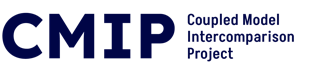|
-


# **Tutorial Objectives**

In the previous tutorial you examined atmospheric surface temperatures. Spatial variations in surface temperature created by uneven solar radiation (e.g., between the Equator and poles), are one of the main drivers of global-scale air movement. Other processes such as the Earth's rotation, storm tracks, and surface topography can also influence global wind patterns. 

By the end of this tutorial, you will be able to:

- Describe the seasonal variations in surface winds.
- Calculate seasonal climatologies and create global maps.
- Compare statistics derived from these climatologies.

In this tutorial, you will again utilize the monthly-mean surface wind fields from ERA5 over a 30-year period.

# **Setup**

In [2]:
# !pip install pythia_datasets
# !pip install cartopy
# !pip install geoviews

In [3]:
from intake import open_catalog
import matplotlib.pyplot as plt
import matplotlib
import os
import pooch
import boto3
import botocore
import numpy as np
import xarray as xr
import warnings
import datetime
from cartopy import crs as ccrs, feature as cfeature
#  Suppress warnings issued by Cartopy when downloading data files
warnings.filterwarnings('ignore')

In [4]:
# @title plot helping function

def set_projection_figure(projection = ccrs.PlateCarree(), figsize =(5, 4.5) ):
    # source:https://foundations.projectpythia.org/core/cartopy/cartopy.html

    projLccNY =  projection #ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(1, 1, 1, projection=projLccNY)

    format_axes(ax)
    #ax.add_feature(cfeature.STATES)
    #ax.add_feature(cfeature.RIVERS)
    return fig, ax

def format_axes(ax):
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None', alpha=0.3 )
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='black', alpha=0.5, linestyle='--')
    gl.xlocator = matplotlib.ticker.MaxNLocator(7)
    gl.ylocator = matplotlib.ticker.MaxNLocator(5)
    gl.xlabels_top  = False
    gl.ylabels_left = False
    #gl.xlines = False

# helping functions:
def geographic_lon_to_360(lon):
    return 360 + lon

def inverted_geographic_lon_to_360(lon):
    return lon - 180

def cbar_label(DD):
    return DD.attrs['long_name'] + ' [' + DD.attrs['units']+ ']'

In [5]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

In [6]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

# **Section 1: Surface Winds**


The large-scale atmospheric circulation significantly influences the climate we experience at different latitudes. The global atmospheric circulation is often depicted as a three-cell structure, as visualized [in this figure showing the surface winds](https://commons.wikimedia.org/wiki/File:Earth_Global_Circulation_-_en.svg):

![Earth Global Circulation - en.svg](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9c/Earth_Global_Circulation_-_en.svg/740px-Earth_Global_Circulation_-_en.svg.png?20190829153037).


This schematic of atmospheric circulation cells reveal meridional (north-south) and zonal (east-west) components of the large-scale surface winds. 

Let's see if you are able to detect these large-scale patterns in reanalysis data!
For this you will load ERA5 wind data from [Pangeo catalog](https://pangeo.io/catalog.html)


## **Section 1.1: Annual Mean Wind Speed**

You should start investigating this data by examining the global surface winds. These winds are represented as vectors, consisting of a zonal component denoted as `u10` and a meridional component denoted as `v10`. 

Recall from the previous tutorial that the magnitude of the wind vector represents the wind speed you will use later in the tutorial, given by:

\begin{align}
||u|| = \sqrt{u^2 + v^2}
\end{align}

To examine long-term changes in the wind field you should visualize the zonal wind component $u$ and the meridional wind component $v$ with monthly-mean data. With the help of `xarray`, you can derive monthly means from higher-resolution data (such as those used in tutorial 2) using the `xr.resample('1M').mean('time')` function.

For your convenience, we have already performed this step, and you can load the data using the following instructions:

- The variable `si10` represents the wind speed in this dataset.
- To calculate the long-term mean, we selected 30 years of data ranging from 1980 to 2010.

Let's grab the reanalysis data from before that we have prepocessed (noting naming convention changes):

In [7]:
# note this can take a few minutes to download
url_era5_mm = "https://osf.io/3q4vs/download" # contains only one file: 'ERA5_surface_winds_mm.nc'
ERA5_mm=xr.open_dataset(pooch.retrieve(url_era5_mm,
                                       known_hash=None)).sel(time=slice('1980', '2010')) # select the timeslice during loading
ERA5_mm

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 312)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2005-12-01
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    si10       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-06 23:25:45 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

Now take the mean zonal surface wind speed.

In [7]:
# take the time mean
ERA5_ANN = ERA5_mm.mean('time') 

To visualize this data, we will be using some helper functions defined in the beginning of the tutorial just to set the map features and aesthetics. Please take a look at them if you are interested in seeing how they work.

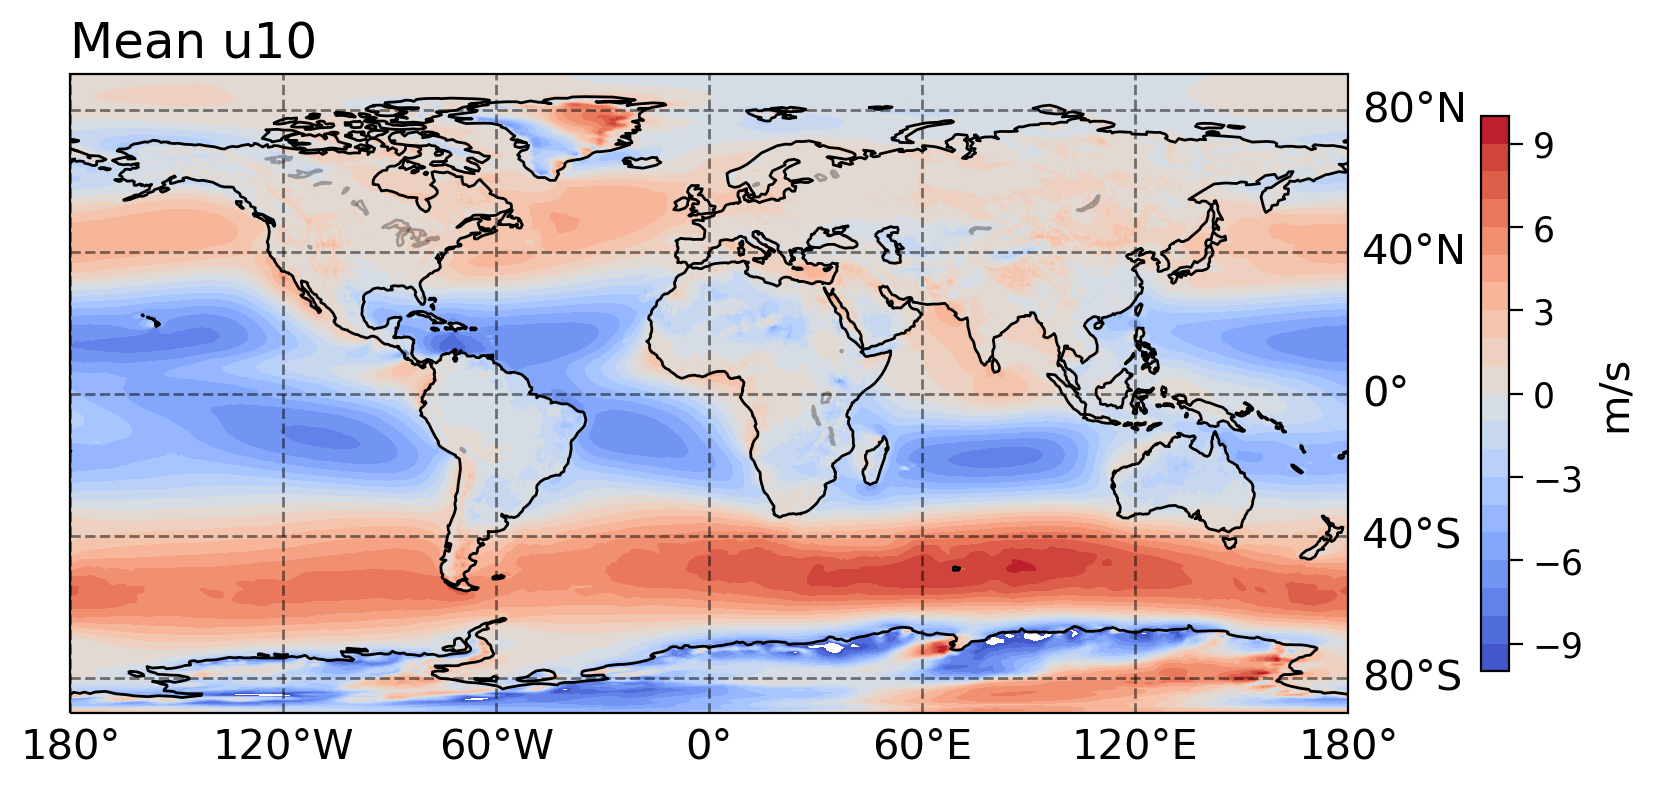

In [8]:
# adjust colorlevels to weaker amplitudes
colorlevels_clim = np.arange(-10, 11, 1)

var = 'u10' # select our variable
fig, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) ) # same plot function as Part I
ax.set_title('Mean '+ var , loc ='left')
dataplot = ax.contourf(ERA5_ANN.longitude, ERA5_ANN.latitude, ERA5_ANN[var],
                       levels = colorlevels_clim,
                       transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
fig.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)

In the zonal wind speed figure you created, there are two distinct wind bands between 35 to 65 degrees both north and south of the equator that blow from west to east (red, positive wind speeds). These mid-latitude wind bands are known as the *westerlies*. Additionally, you can see that winds predominantly blow from the east to the west (blue, negative wind speeds) in the tropics (less than 30° N/S), and are referred to as the *easterlies*.


### **Coding Exercise 1.1**
Reproduce the previous figure, but modify it to plot **meridional wind** rather than **zonal wind**

In [9]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise: Reproduce the previous figure, but modify it to plot meridional wind rather than zonal wind")
#################################################
var = ...
fig, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )
ax.set_title('Mean '+ var , loc ='left')
dataplot = ax.contourf(ERA5_ANN.longitude, ERA5_ANN.latitude, ERA5_ANN[var],
                       levels = colorlevels_clim,
                       transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
fig.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)


NotImplementedError: Student exercise: Reproduce the previous figure, but modify it to plot meridional wind rather than zonal wind

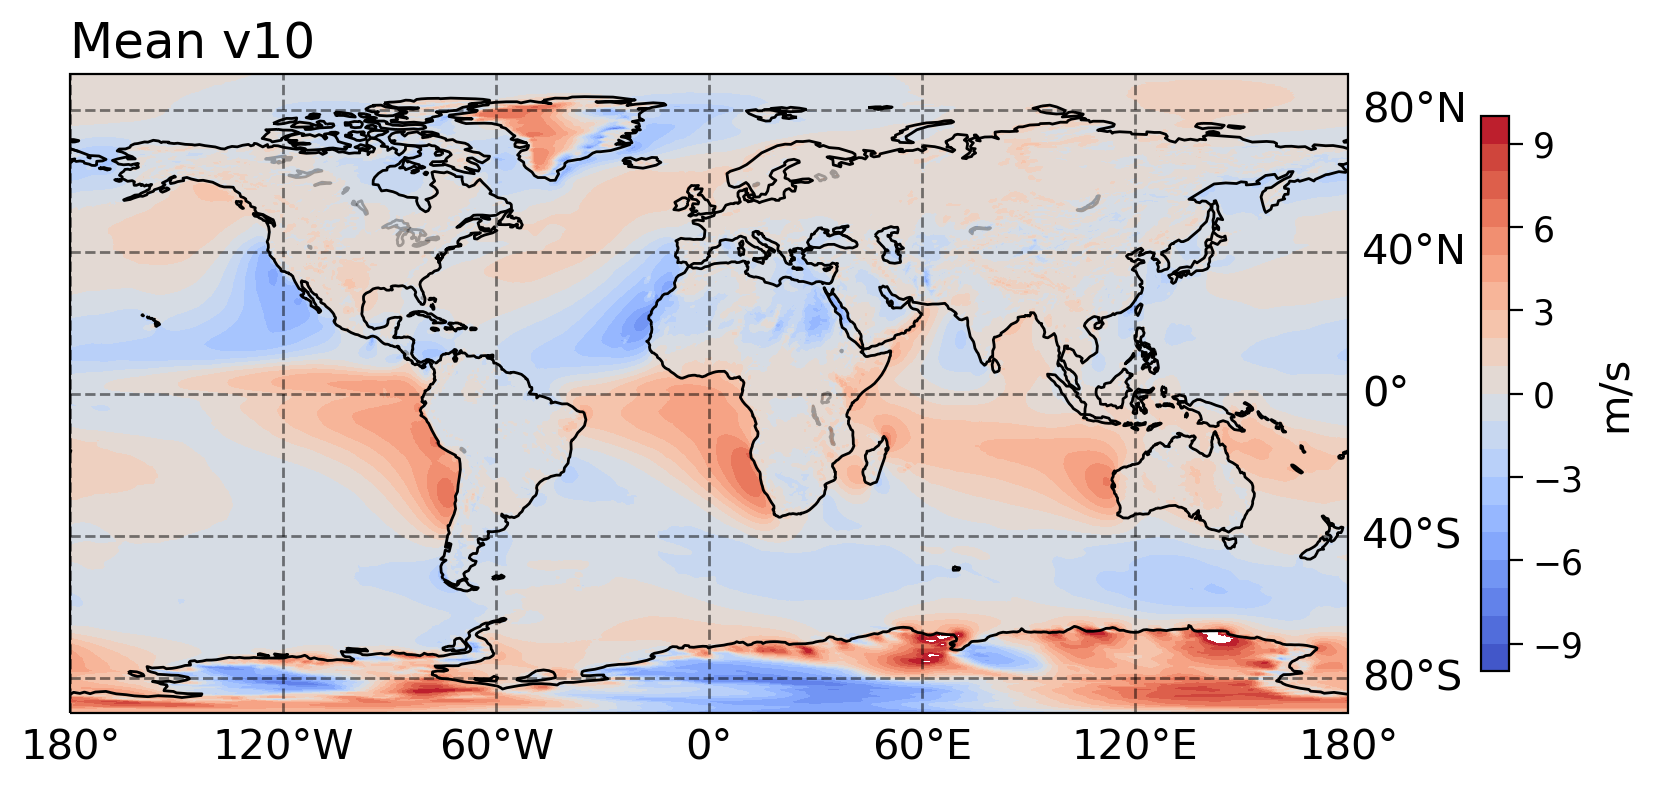

In [10]:
# to_remove solution
var = 'v10'
fig, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )
ax.set_title('Mean '+ var , loc ='left')
dataplot = ax.contourf(ERA5_ANN.longitude, ERA5_ANN.latitude, ERA5_ANN[var],
                       levels = colorlevels_clim,
                       transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
fig.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)


There are strong southward winds in the subtropics of the Northern Hemisphere (blue, negative wind speed), and northward winds in the subtropics of the Southern Hemisphere (red, positive wind speed). The meridional winds are strongest on the western side of the continents. 

### **Questions 1.1**
1. Among the three atmospheric "cells" (the Hadley Cell, Ferrel Cell, and Polar Cell) depicted in the figure from Section 1 above, which ones correspond to the zonal wind bands that we visualized in the first plot above? 
2. How do the zonal and meridional winds compare in magnitude, longitude, and latitude?

In [11]:
# to_remove explanation
'''
1. The Hadley Cell is the tropical region containing the easterlies (a.k.a. trade winds), and the Ferrel Cell is the mid-latitude region containing the westerlies.
2. Meridional winds are typically weaker and less variable than zonal winds. This is due to the general circulation of the atmosphere, which primarily moves air in the east-west direction rather than north-south. 
''';

## **Section 1.2 : Zonal-mean Wind Speed**

To examine the latitudinal variation in the surface winds, you can plot the zonal mean of the annual mean zonal and meridional winds:


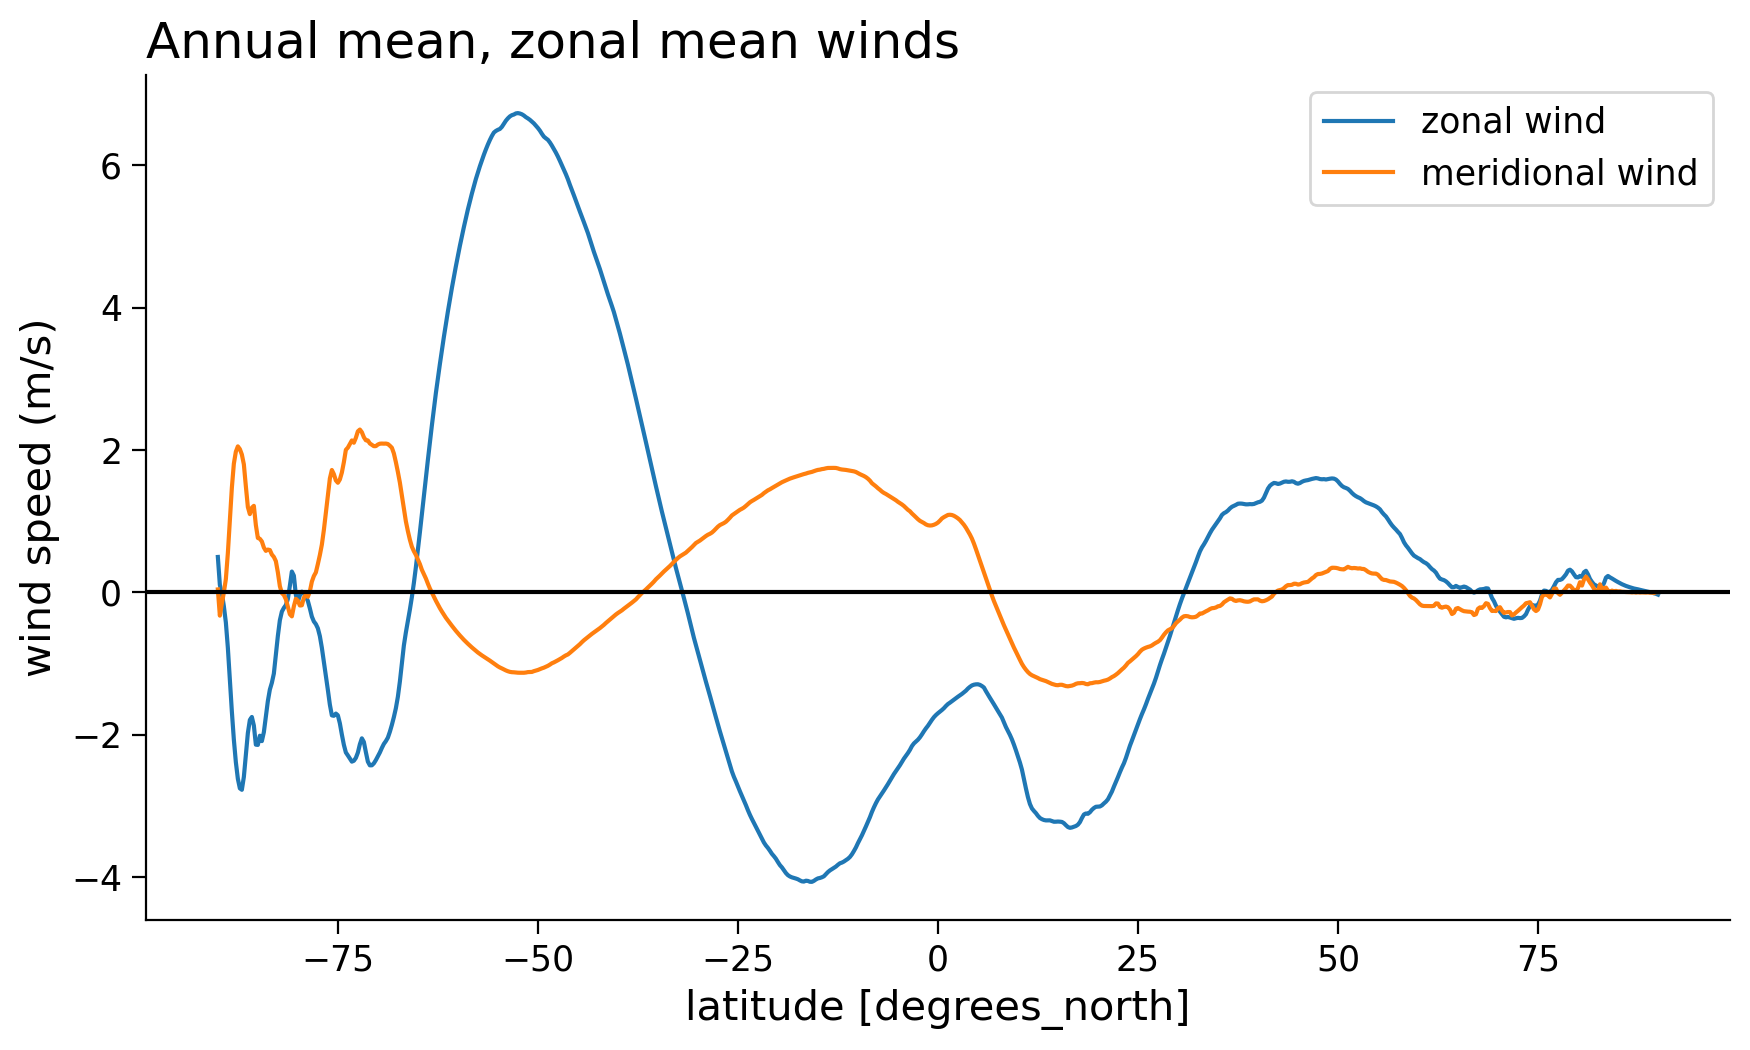

In [12]:
fig, ax = plt.subplots(figsize = (9, 5.5) )
ERA5_ANN.mean('longitude')['u10'].plot(label = 'zonal wind',ax=ax) # find the u10 mean value over the latitude 
ERA5_ANN.mean('longitude')['v10'].plot(label = 'meridional wind',ax=ax) # find the v10 mean value over the latitude 
ax.legend() # add legend
ax.set_title('Annual mean, zonal mean winds', loc= 'left' ) # add title
ax.set_ylabel('wind speed (m/s)')
ax.axhline(0, color = 'black') # add a black line at x=0

### **Questions 1.2**
1. Considering the zonal-mean wind speed figure provided, what factors contribute to the noticeable disparities between the Northern and Southern Hemispheres in terms of wind patterns?

In [13]:
# to_remove explanation

""" 
1. The continents influence the strength of the winds, and since the continents are so unevenly positioned on on the planet, the winds are weaker in the North then in the South. The strongest winds occur in the Southenr Ocean, where we have little land, and the winds must get very strong to create the same amount of drag as over the large land masses in the Northern Hemisphere.
""";


# **Section 2: Monthly Climatology**

Now, you should examine how the zonal mean winds vary throughout the seasons. You will focus on the zonal wind component and create a special type of diagram called a Hoffmöller diagram. In this diagram, the horizontal axis represents latitude, while the vertical axis represents time.

By using the Hoffmöller diagram, you can visualize how the average east-west winds change with each season.


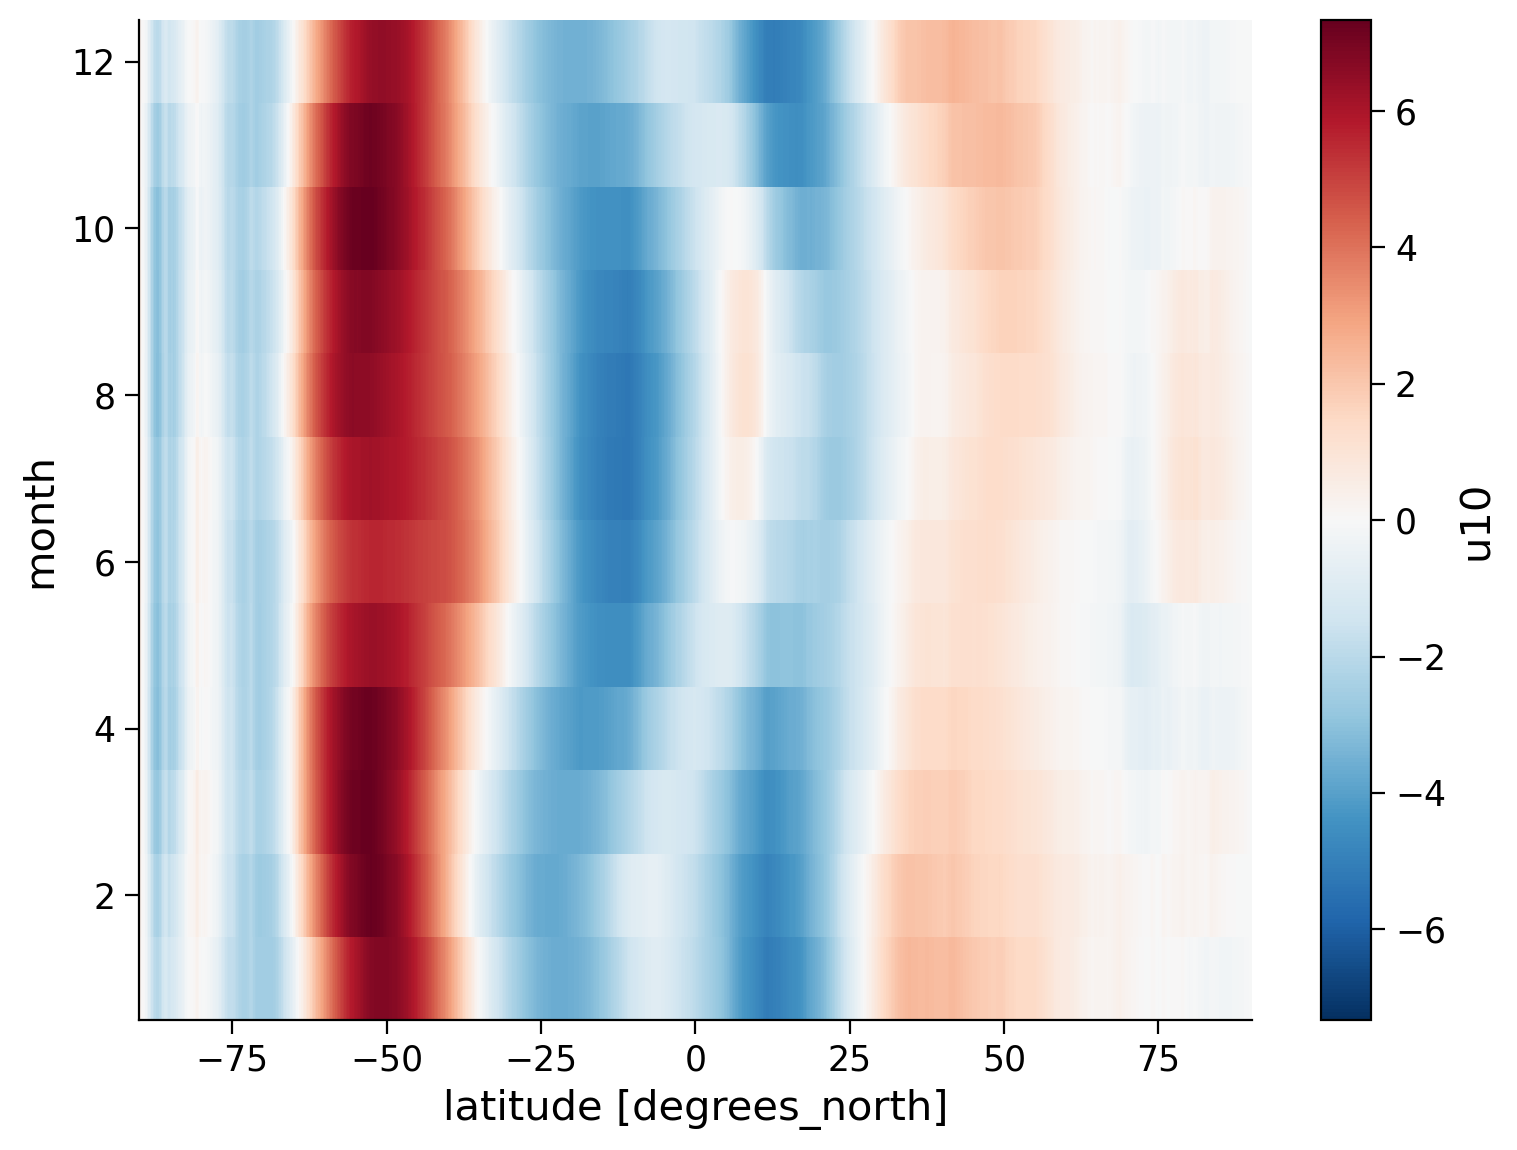

In [14]:
# the groupby command regroups the data by month, such that all Januarys, all Februaries, .. and so on are taken the mean over
# note how we use several commands in one line. python perfom them by order. slice (long, u10), groupby, mean and lastely plot. 
ERA5_mm.mean('longitude')['u10'].groupby('time.month').mean().plot()

### **Coding Exercises 2**

Extend the above analysis to create a Hoffmöller diagram of the meridional winds.

In [ ]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise: Extend the above analysis to create a Hoffmöller diagram of the meridional winds.")
#################################################

ERA5_mm.mean('longitude')['...'].groupby('time.month').mean().plot()

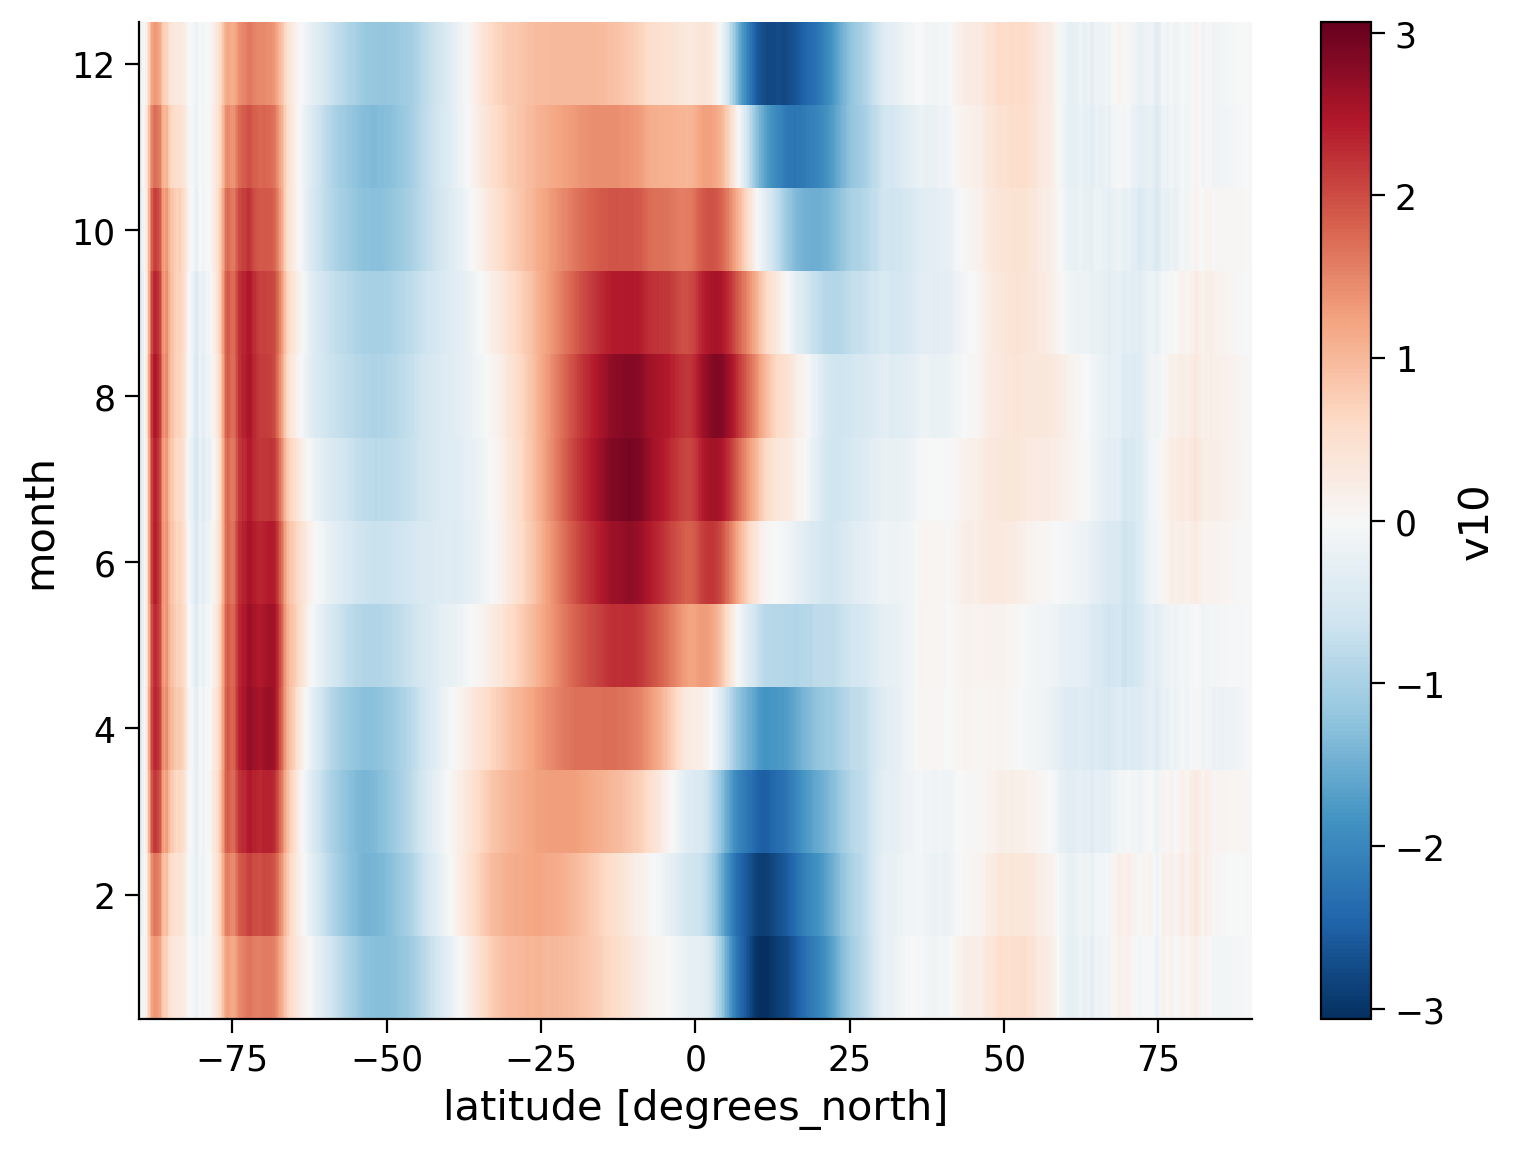

In [15]:
# to_remove solution

ERA5_mm.mean('longitude')['v10'].groupby('time.month').mean().plot()

*Note:*
- The winds in the Southern Hemisphere appear to be generally stronger compared to the Northern Hemisphere.
- The period between June and September shows strong meridional winds. These winds result from the seasonal variation of the Hadley cell. During the winter hemisphere in each respective hemisphere, the Hadley cell becomes much stronger, leading to the intensification of meridional winds.

# **Summary**

Within this tutorial, you analysed the global atmospheric circulation by using ERA5 reanalysis data. You explored the distribution of westerlies and easterlies across the globe, observed their seasonal variations. You observed that the strongest winds were found to occur over the Southern Ocean.

## **Additional Reading: Extra-tropical Storms**

In the wind speed figure, you can notice areas of strong winds over the Southern Ocean, North Pacific, and North Atlantic. These powerful winds are caused by weather systems known as extratropical storms or mid-latitude cyclones. These storms occur in the middle latitudes, between 30 and 60 degrees north or south of the equator. During winter, they are particularly strong over the Southern Ocean and the oceans in the Northern Hemisphere.

Extratropical storms form when warm and cold air masses interact. They have a low-pressure center and produce winds that circulate counterclockwise in the Northern Hemisphere and clockwise in the Southern Hemisphere. These storms can be intense, bringing strong winds, heavy rain, snow, and sleet. They often lead to problems like flooding, power outages, and disruptions in transportation.

The strength of these storms depends on factors such as the temperature difference between air masses, the speed of the jet stream, and the amount of moisture in the air. If you want to learn more about extratropical storms, you can refer to basic meteorology and atmospheric dynamics resources, or you can explore online sources such as the following:

- Wikipedia: [Extratropical Cyclone](https://en.wikipedia.org/wiki/Extratropical_cyclone)
- Pressbooks: [Chapter 13 - Extratropical Cyclones](http://pressbooks-dev.oer.hawaii.edu/atmo/chapter/chapter-13-extratropical-cyclones/)

Although an individual storm may last only a few days and doesn't create significant ocean currents, the continuous winds and the occurrence of multiple storms over a year can influence the development of ocean currents. These currents are a response to the persistent wind patterns.

## **Resources**

Data from this tutorial can be accessed [here](https://registry.opendata.aws/ecmwf-era5/).